In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
np.random.seed(42)
data = pd.read_csv('../data/siteA.csv')

In [3]:
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [4]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 4 columns):
Date_Name        66160 non-null datetime64[ns]
subCategory      66160 non-null object
Purchase_Hour    66160 non-null int64
sales            66160 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB
None


In [5]:
# Make a dataframe for each category, and put it into a list...len(list) = 16
# Essentially becomes a list of dataframe
def make_dataframe(df, lis):
    f = lambda x: df[df['subCategory'] == x]
    return map(f, lis)

temp_list = data['subCategory'].unique()
splitted_data = make_dataframe(data, temp_list)
print len(splitted_data)
print splitted_data[2][0:5]

16
      Date_Name subCategory  Purchase_Hour   sales
9259 2016-03-01           C              7  460.34
9260 2016-03-04           C              7  414.03
9261 2016-03-07           C              7  370.37
9262 2016-03-08           C              7  368.68
9263 2016-03-11           C              7  439.15


In [47]:
# Looks like some have missing dates, like category #10 has only half of the data.
for i in range(0,16):
    temp_A = splitted_data[i].groupby(by=['Date_Name'])['sales'].sum()
    print i, ':', temp_A.shape

print 'i= ', i
temp_A = splitted_data[i].groupby(by=['Date_Name'])['sales'].sum()
print temp_A.index

0 : (345,)
1 : (345,)
2 : (345,)
3 : (319,)
4 : (339,)
5 : (345,)
6 : (345,)
7 : (345,)
8 : (330,)
9 : (343,)
10 : (194,)
11 : (345,)
12 : (345,)
13 : (346,)
14 : (300,)
15 : (328,)
i=  15
DatetimeIndex(['2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01', '2015-10-02', '2015-10-03',
               '2015-10-04', '2015-10-05',
               ...
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', name=u'Date_Name', length=328, freq=None)


In [44]:
idx = pd.date_range('09-26-2015', '09-30-2016')
temp_A.index = pd.DatetimeIndex(temp_A.index)
temp_A = temp_A.reindex(idx, fill_value=0)
print temp_A.index
print temp_A.head()
print temp_A.tail()

DatetimeIndex(['2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01', '2015-10-02', '2015-10-03',
               '2015-10-04', '2015-10-05',
               ...
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', length=371, freq='D')
2015-09-26     52.27
2015-09-27     94.35
2015-09-28    123.47
2015-09-29     79.09
2015-09-30    126.08
Freq: D, Name: sales, dtype: float64
2016-09-26    48.67
2016-09-27    32.59
2016-09-28    16.29
2016-09-29    15.89
2016-09-30    14.49
Freq: D, Name: sales, dtype: float64


In [9]:
# Let's see which dates have 0 sales...
print temp_A[temp_A == 0]

2015-12-20    0.0
2015-12-24    0.0
2015-12-25    0.0
2015-12-26    0.0
2015-12-27    0.0
2015-12-28    0.0
2015-12-29    0.0
2015-12-30    0.0
2015-12-31    0.0
2016-01-01    0.0
2016-01-02    0.0
2016-01-03    0.0
2016-02-27    0.0
2016-03-31    0.0
2016-04-30    0.0
2016-05-01    0.0
2016-05-08    0.0
2016-05-22    0.0
2016-05-23    0.0
2016-05-29    0.0
2016-05-31    0.0
2016-06-30    0.0
2016-07-01    0.0
2016-07-03    0.0
2016-07-31    0.0
2016-08-01    0.0
Name: sales, dtype: float64


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


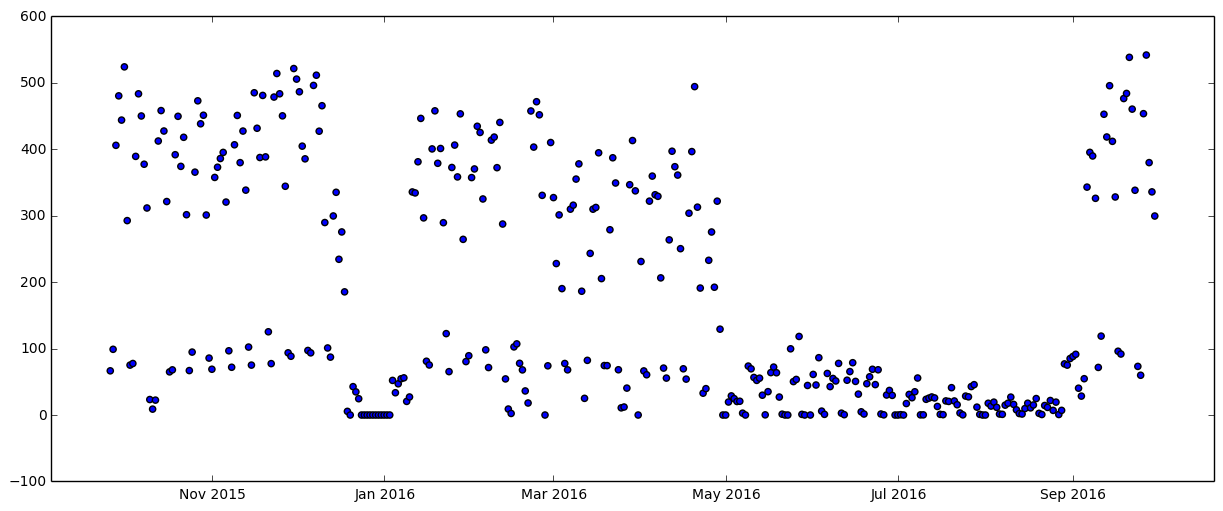

In [10]:
# Time series in scattered plot format...
plt.scatter(temp_A.index, temp_A)

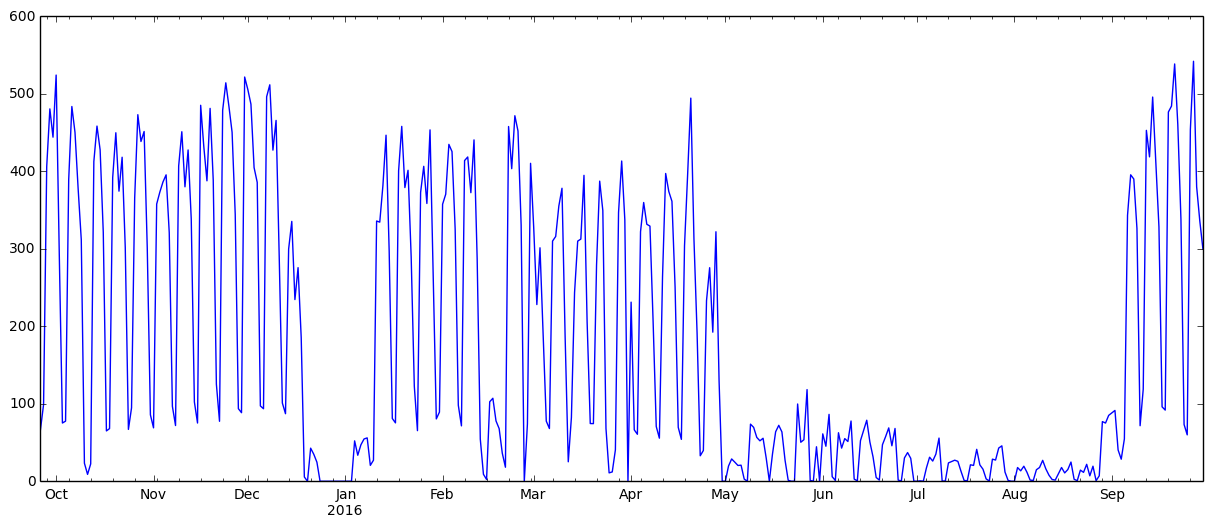

In [11]:
temp_A.plot()

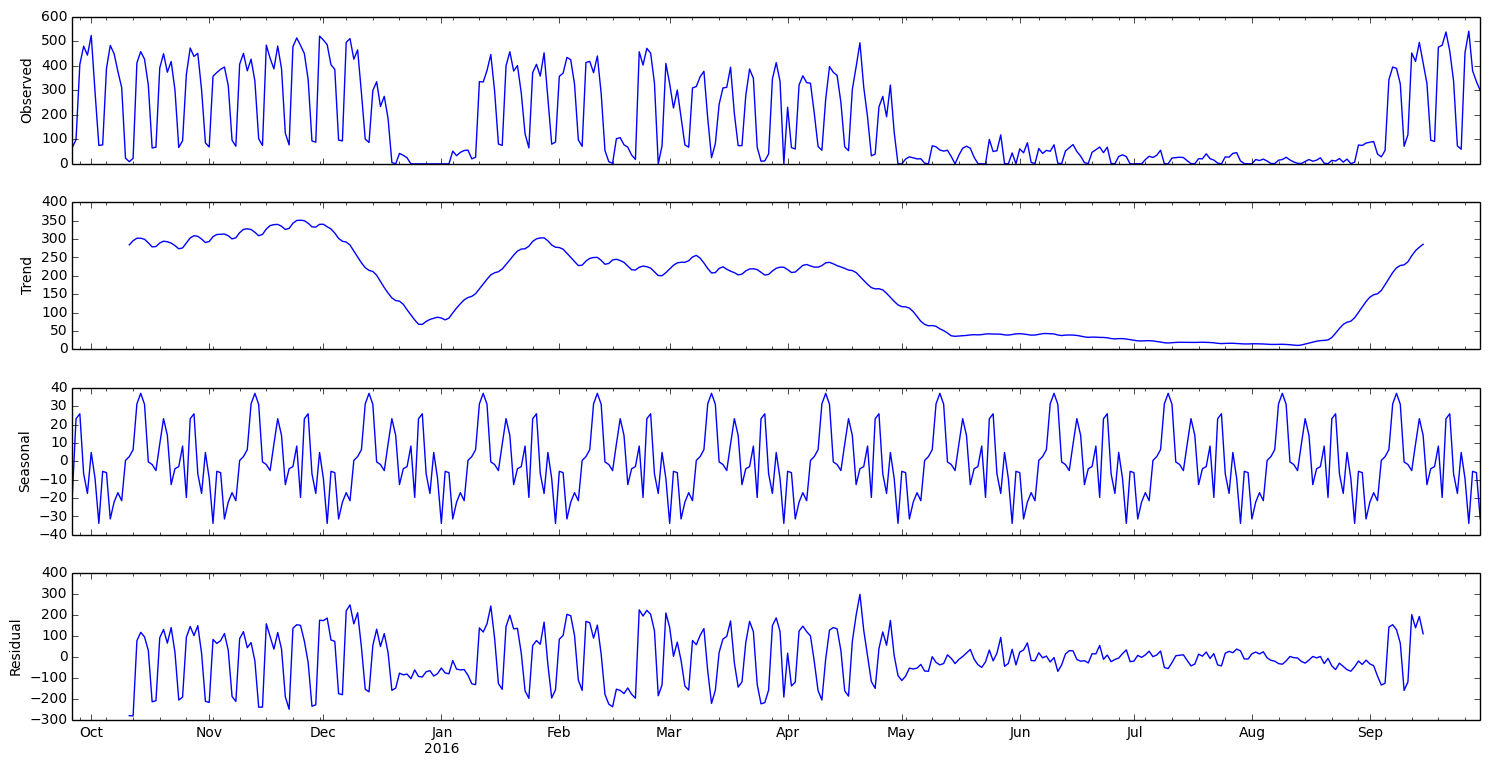

In [12]:
# Category A, seasonal decomposition plots...
decomposition = seasonal_decompose(temp_A, freq=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [13]:
# A function to test serie's stationarity... 
def test_stationarity(timeseries, category):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('{} - Rolling Mean & Standard Deviation'.format(category))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


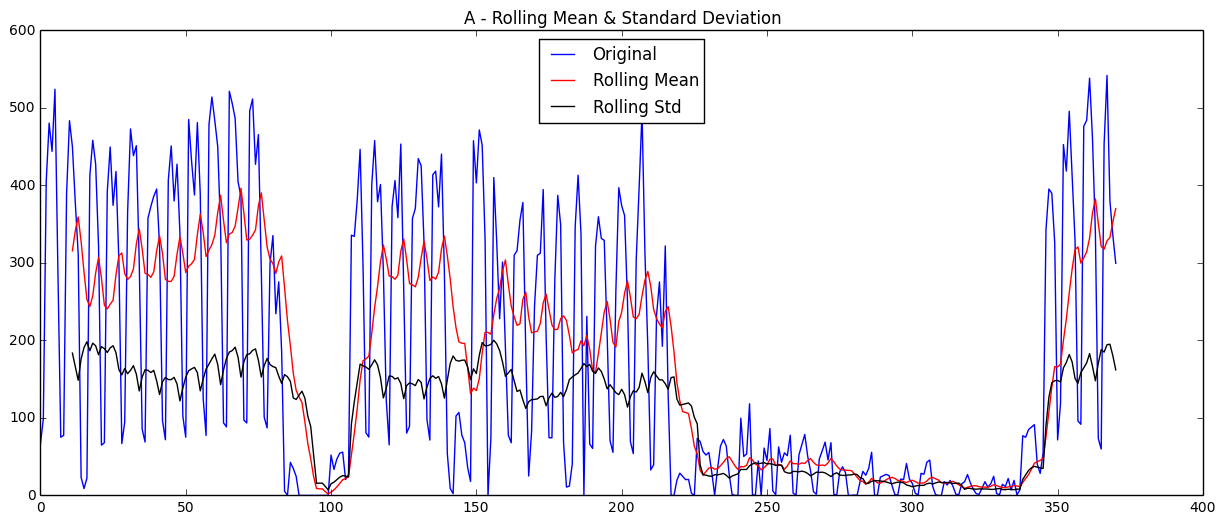

Results of Dickey-Fuller Test:
Test Statistic                  -2.295463
p-value                          0.173436
#Lags Used                      14.000000
Number of Observations Used    356.000000
Critical Value (5%)             -2.869693
Critical Value (1%)             -3.448853
Critical Value (10%)            -2.571114
dtype: float64


In [14]:
test_stationarity(temp_A, 'A')

### Category 'A' is not stationary...let's make it stationary!

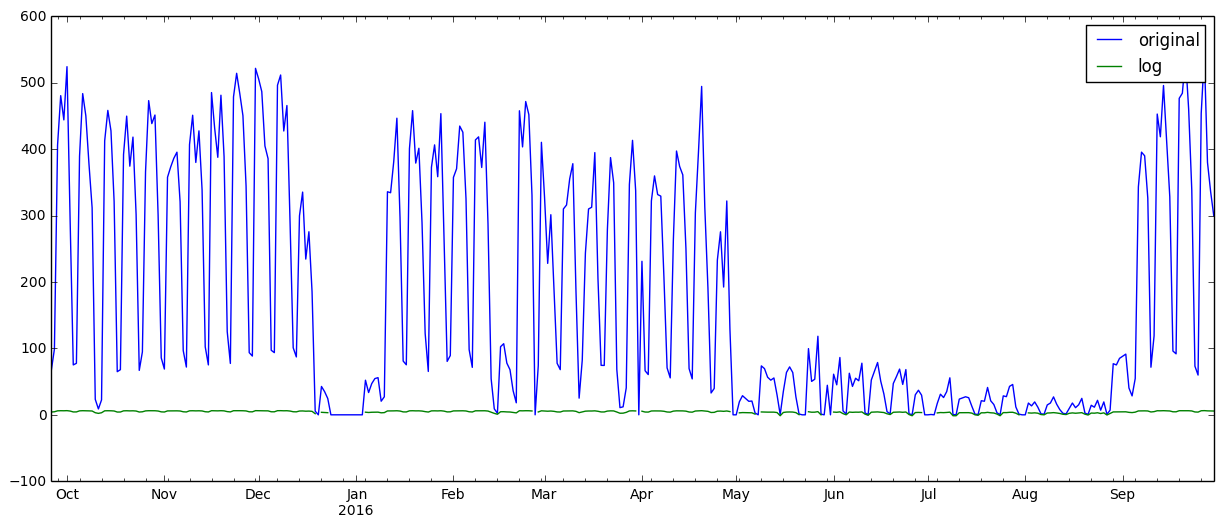

In [15]:
temp_A_log= temp_A.apply(lambda x: np.log(x))
temp_A.plot(label='original')
temp_A_log.plot(label='log')
plt.legend()

0.0


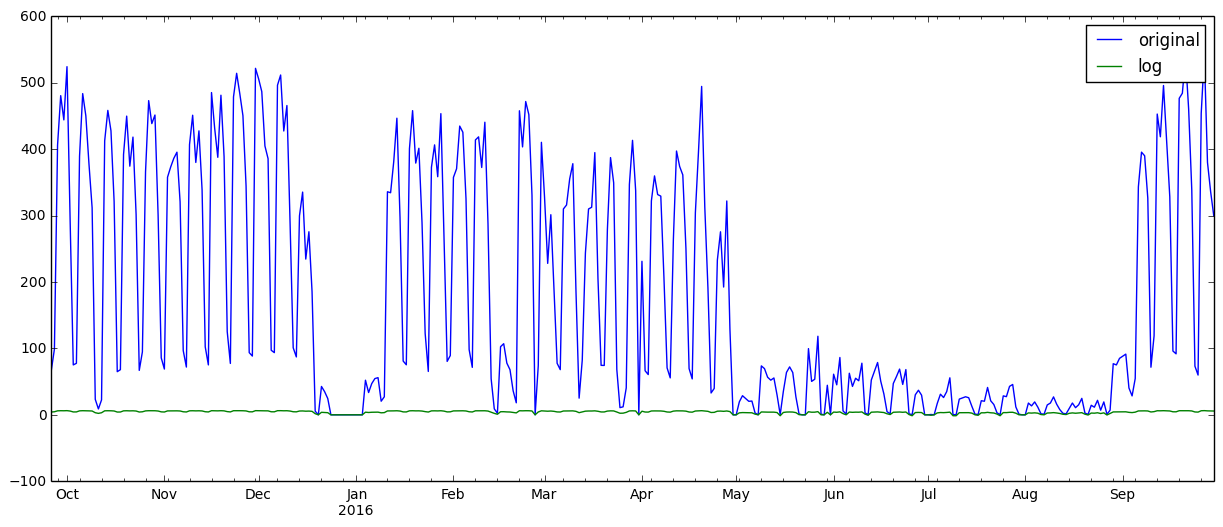

In [16]:
# Replace inf, -inf with 0...because after we log(0), we got inf values

temp_A_log = temp_A_log.replace([np.inf, -np.inf], 0)
print temp_A_log['2015-12-20']
temp_A.plot(label='original')
temp_A_log.plot(label='log')
plt.legend()

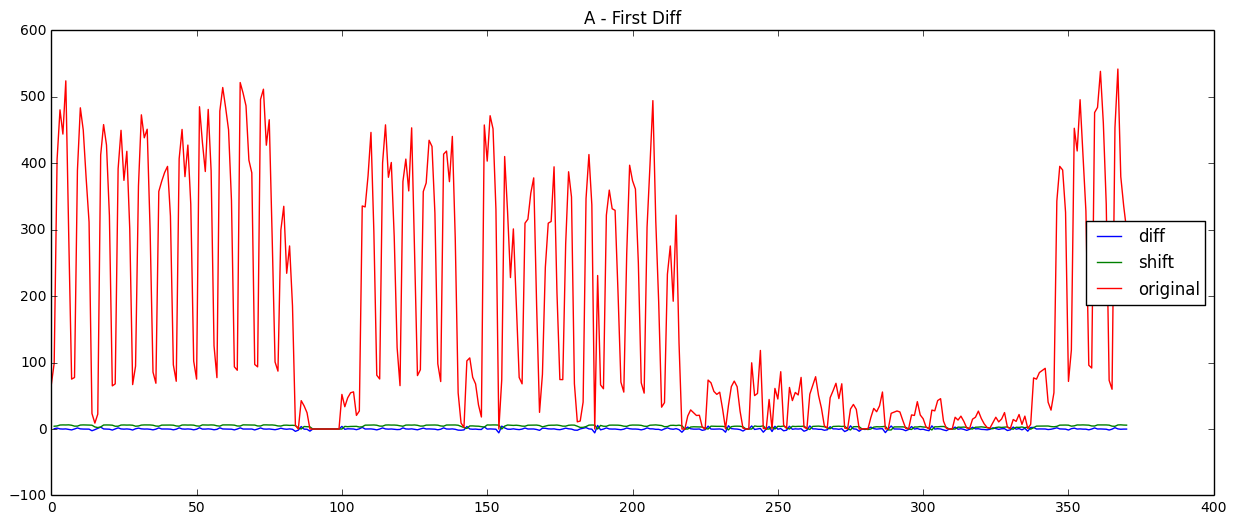

In [17]:
# Differencing to deal with trend...
# Log first difference

temp_A_diff = temp_A_log - temp_A_log.shift()
plt.plot(temp_A_diff, label='diff')
plt.plot(temp_A_log.shift(), label='shift')
plt.plot(temp_A, label='original')
plt.legend(loc='best')
plt.title('A - First Diff')

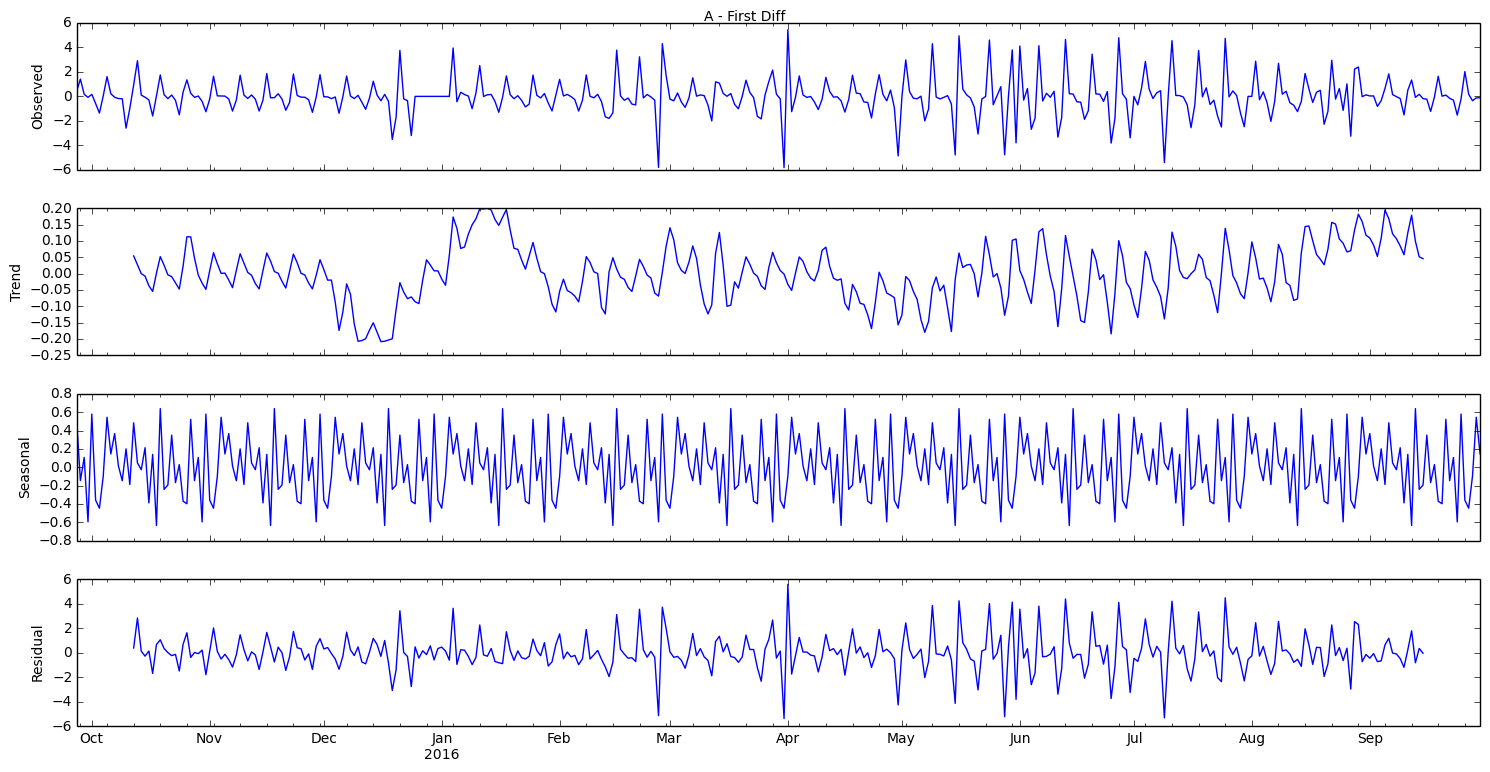

In [18]:
temp_A_diff.dropna(inplace=True)
# Category A, seasonal decomposition plots...
decomposition_diff = seasonal_decompose(temp_A_diff, freq=30)
fig = plt.figure()
fig = decomposition_diff.plot()
fig.set_size_inches(15, 8)
fig.suptitle('A - First Diff')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


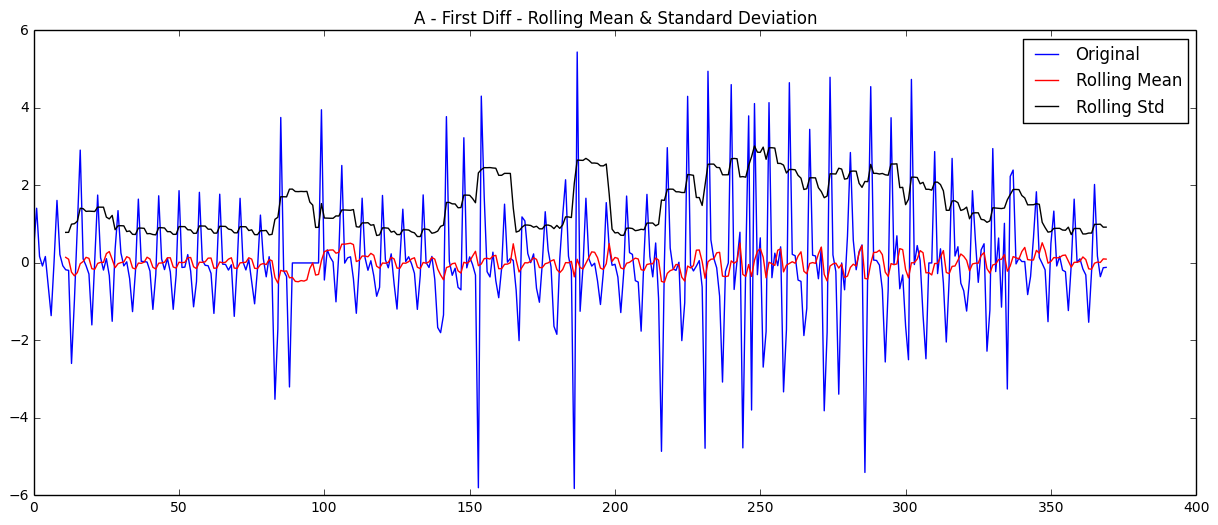

Results of Dickey-Fuller Test:
Test Statistic                -5.867731e+00
p-value                        3.295171e-07
#Lags Used                     1.300000e+01
Number of Observations Used    3.560000e+02
Critical Value (5%)           -2.869693e+00
Critical Value (1%)           -3.448853e+00
Critical Value (10%)          -2.571114e+00
dtype: float64


In [19]:
# Let's see the Dickey-Fuller test after taking the diff...
test_stationarity(temp_A_diff, 'A - First Diff')

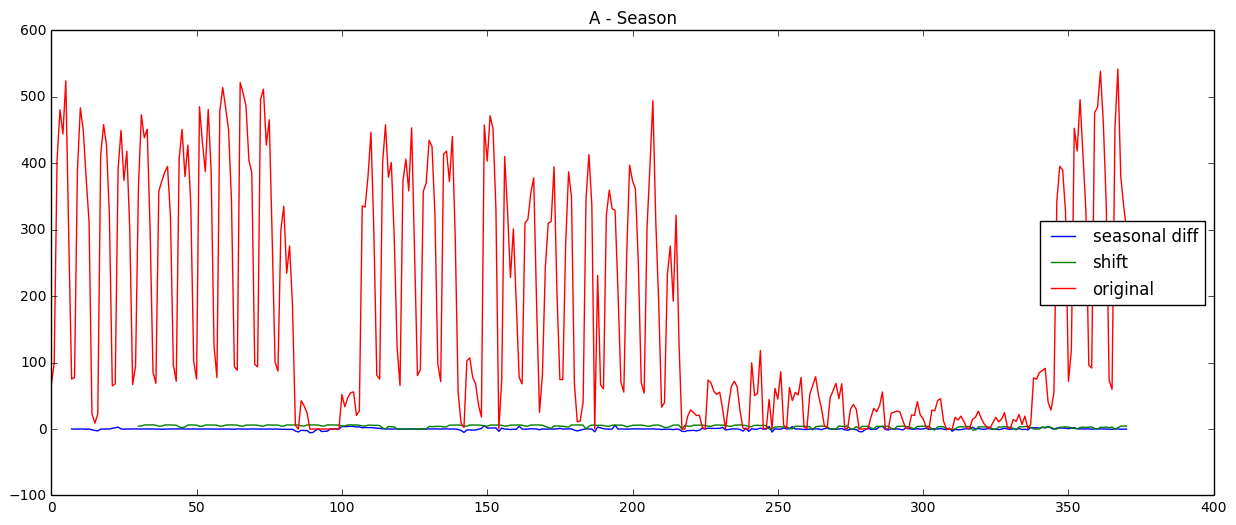

In [20]:
# Differencing to deal with seasonality...
# Log seasonal difference

temp_A_season = temp_A_log - temp_A_log.shift(7)
plt.plot(temp_A_season, label='seasonal diff')
plt.plot(temp_A_log.shift(30), label='shift')
plt.plot(temp_A, label='original')
plt.legend(loc='best')
plt.title('A - Season')

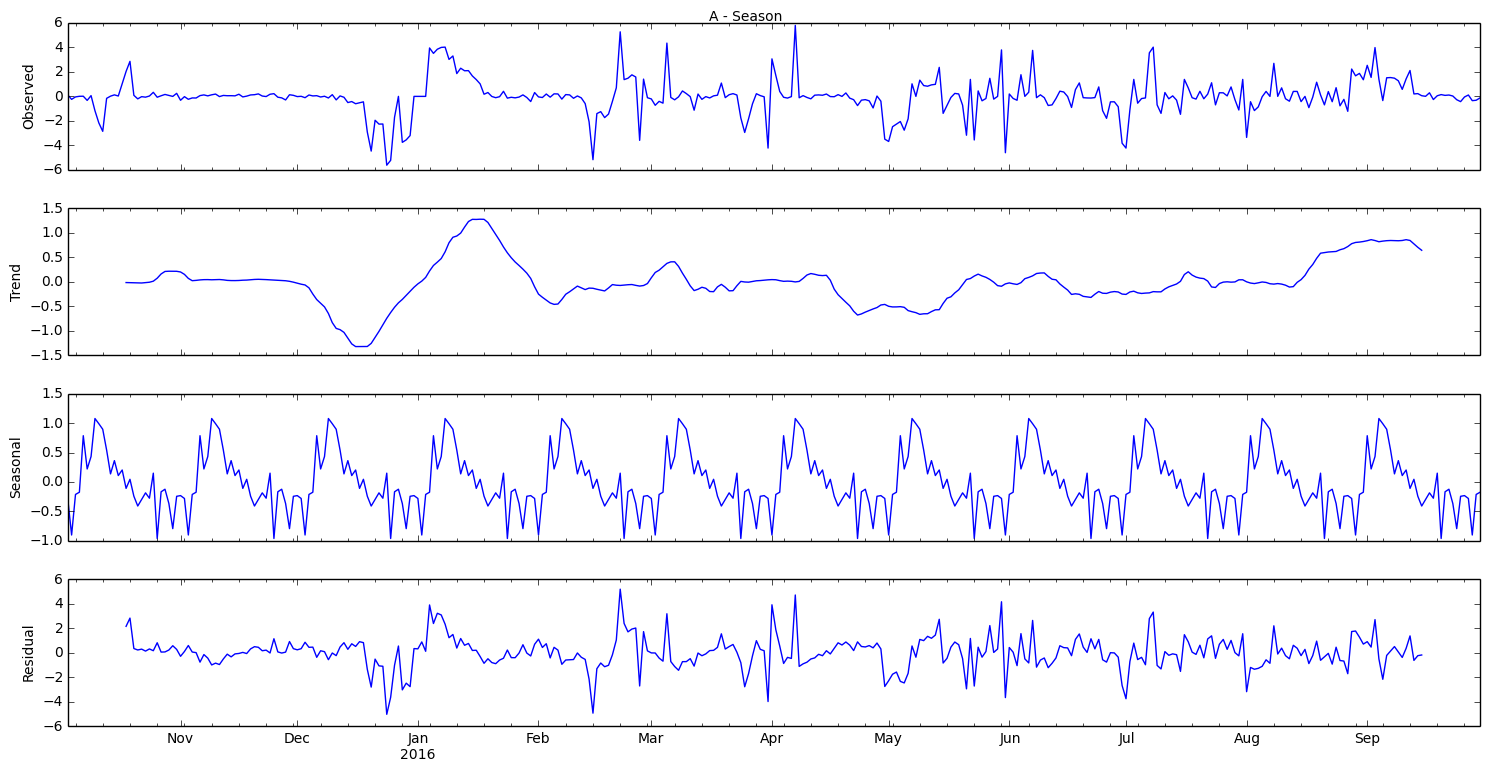

In [21]:
temp_A_season.dropna(inplace=True)
# Category A, seasonal decomposition plots...

decomposition_season = seasonal_decompose(temp_A_season, freq=30)
fig = plt.figure()
fig = decomposition_season.plot()
fig.set_size_inches(15, 8)
fig.suptitle('A - Season')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


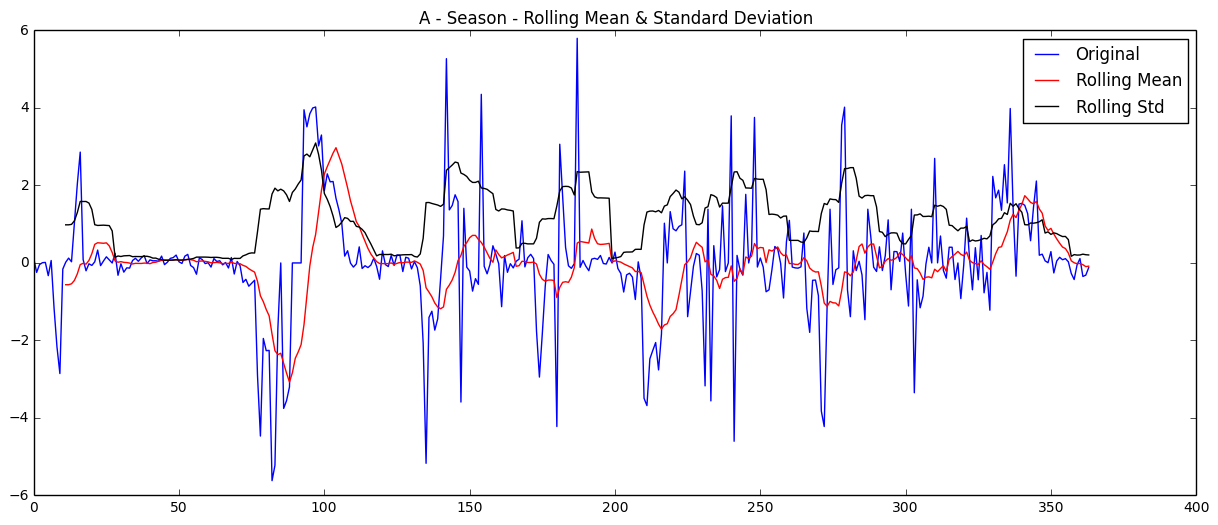

Results of Dickey-Fuller Test:
Test Statistic                  -5.210390
p-value                          0.000008
#Lags Used                      14.000000
Number of Observations Used    349.000000
Critical Value (5%)             -2.869857
Critical Value (1%)             -3.449227
Critical Value (10%)            -2.571201
dtype: float64


In [22]:
# Let's see the Dickey-Fuller test after taking the log & diff...
test_stationarity(temp_A_season, 'A - Season')

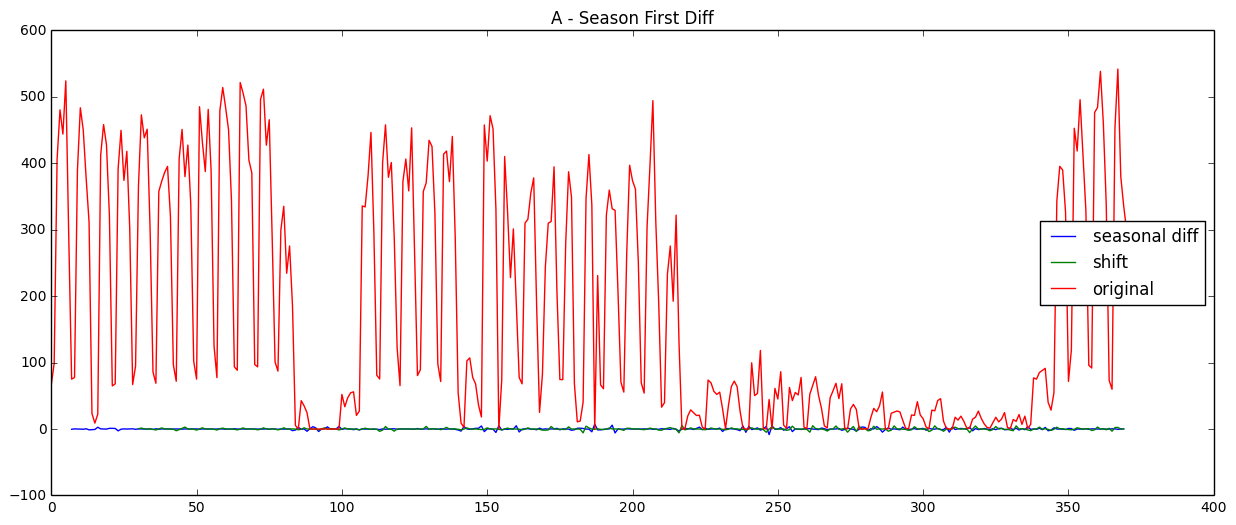

In [23]:
# Differencing to deal with seasonality...
# Log seasonal first difference

temp_A_season_diff = temp_A_diff - temp_A_diff.shift(7)
plt.plot(temp_A_season_diff, label='seasonal diff')
plt.plot(temp_A_diff.shift(30), label='shift')
plt.plot(temp_A, label='original')
plt.legend(loc='best')
plt.title('A - Season First Diff')

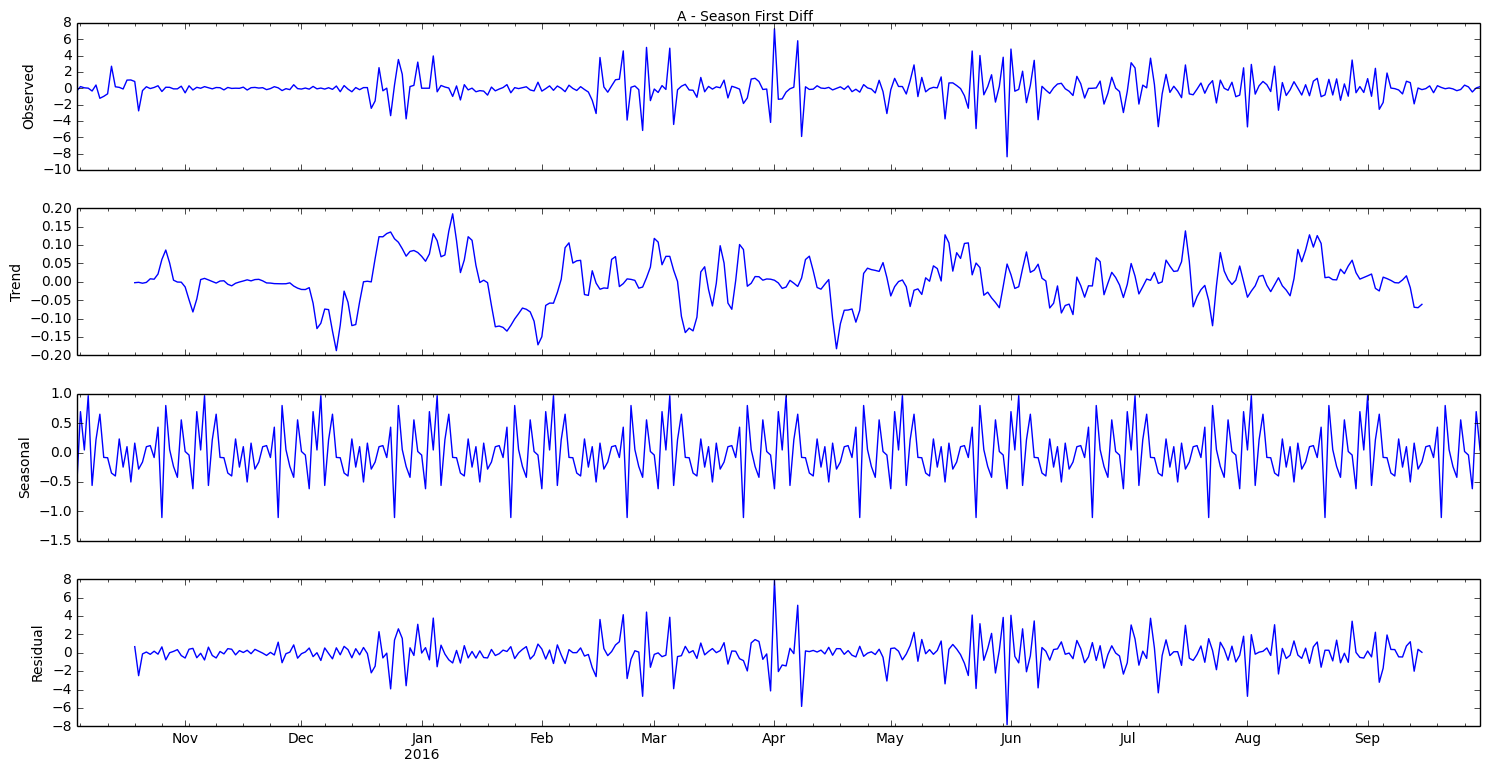

In [24]:
temp_A_season_diff.dropna(inplace=True)
# Category A, seasonal decomposition plots...

decomposition_season = seasonal_decompose(temp_A_season_diff, freq=30)
fig = plt.figure()
fig = decomposition_season.plot()
fig.set_size_inches(15, 8)
fig.suptitle('A - Season First Diff')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


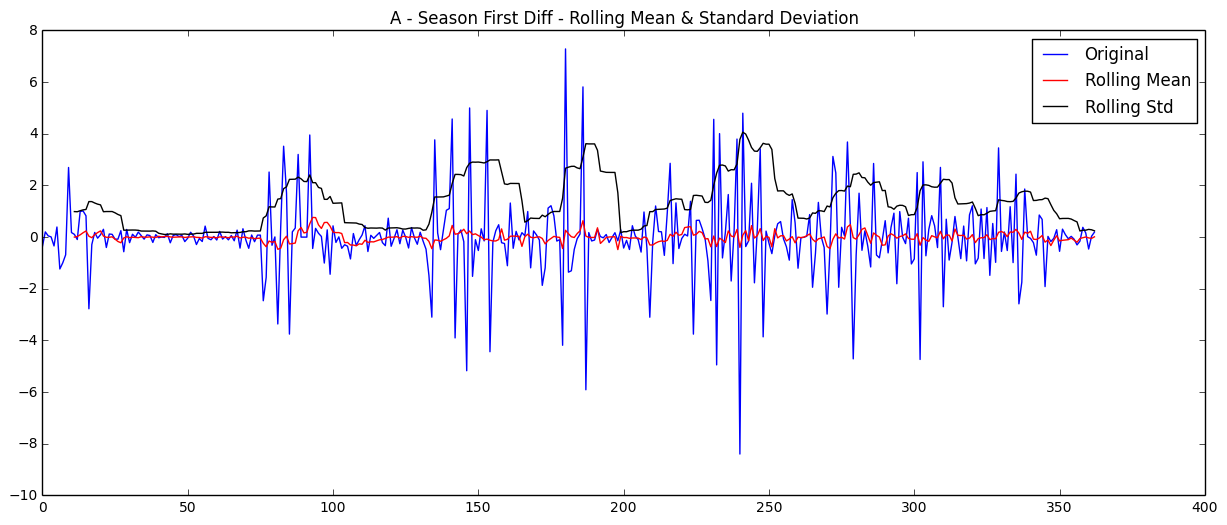

Results of Dickey-Fuller Test:
Test Statistic                -7.089922e+00
p-value                        4.437585e-10
#Lags Used                     1.700000e+01
Number of Observations Used    3.450000e+02
Critical Value (5%)           -2.869954e+00
Critical Value (1%)           -3.449447e+00
Critical Value (10%)          -2.571253e+00
dtype: float64


In [25]:
# Let's see the Dickey-Fuller test after taking the log, diff, and season diff...
test_stationarity(temp_A_season_diff, 'A - Season First Diff')

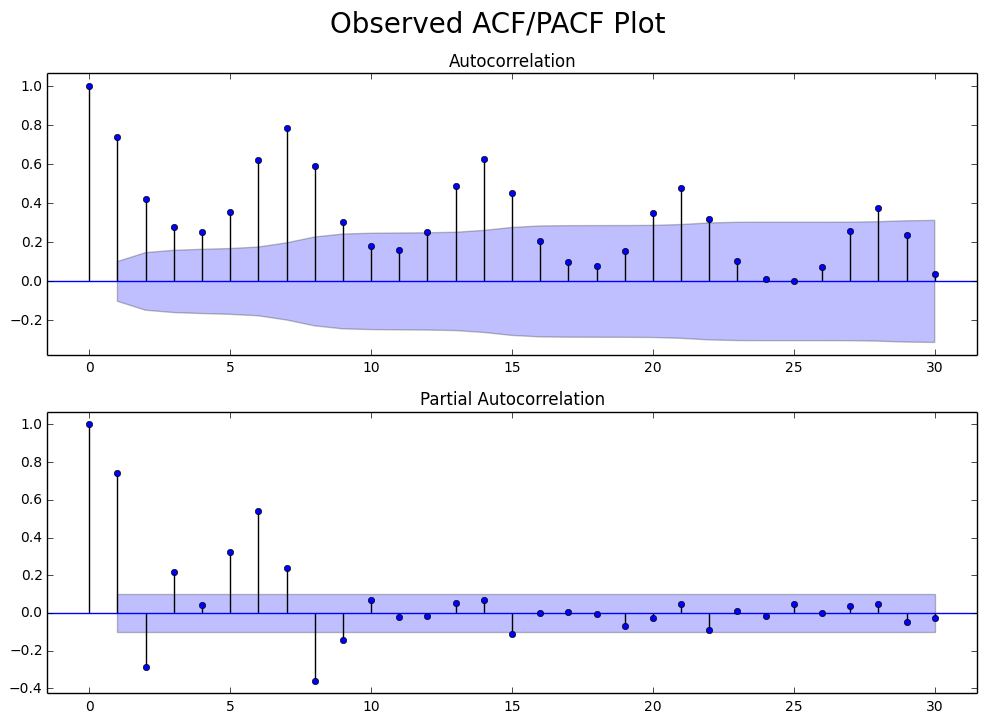

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A, lags=30, ax=ax2)
fig.suptitle('Observed ACF/PACF Plot', fontsize=20)

### PACF cuts off at 1, probably AR(1) model...

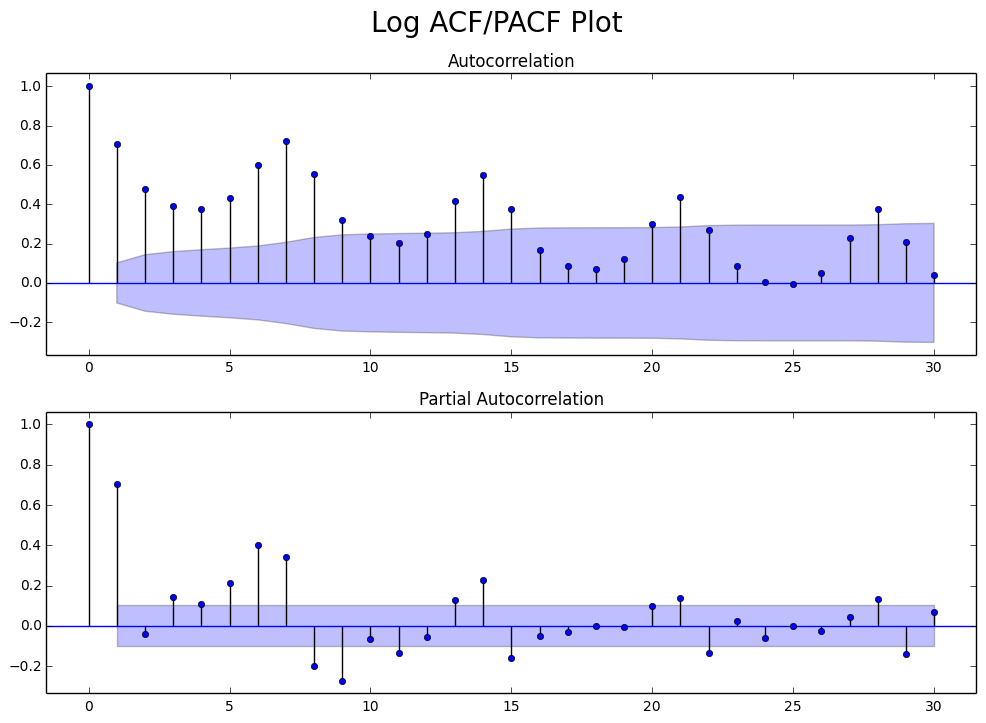

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_log, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_log, lags=30, ax=ax2)
fig.suptitle('Log ACF/PACF Plot', fontsize=20)

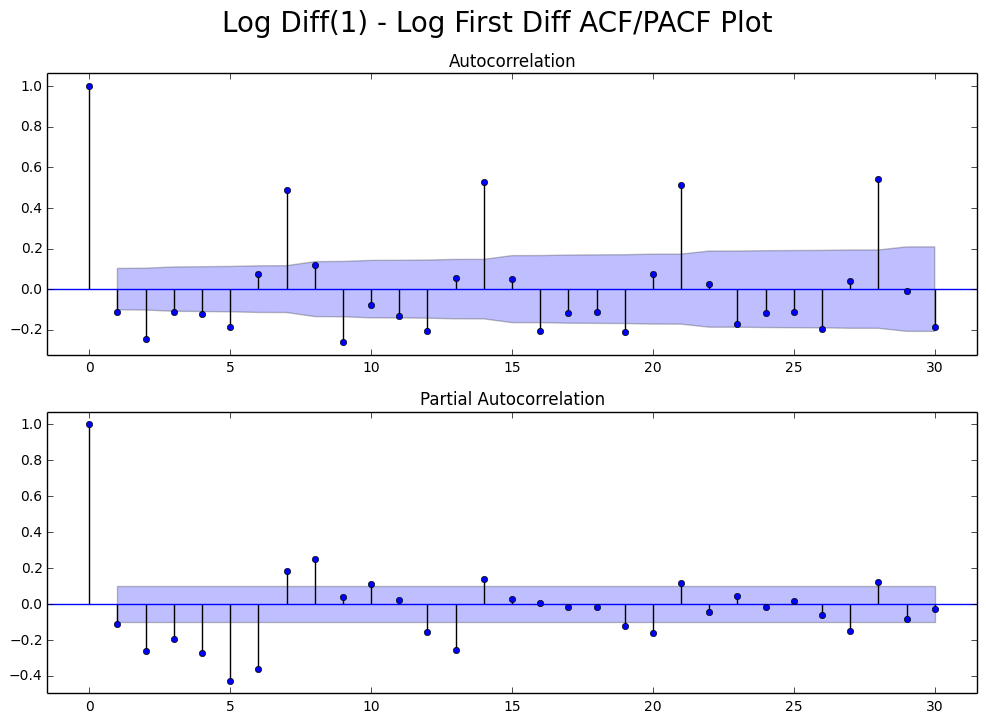

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_diff, lags=30, ax=ax2)
fig.suptitle('Log Diff(1) - Log First Diff ACF/PACF Plot', fontsize=20)

### - Log diff has both tails off, thus, ARMA behavior.
### - So...the observed data may be ARIMA...

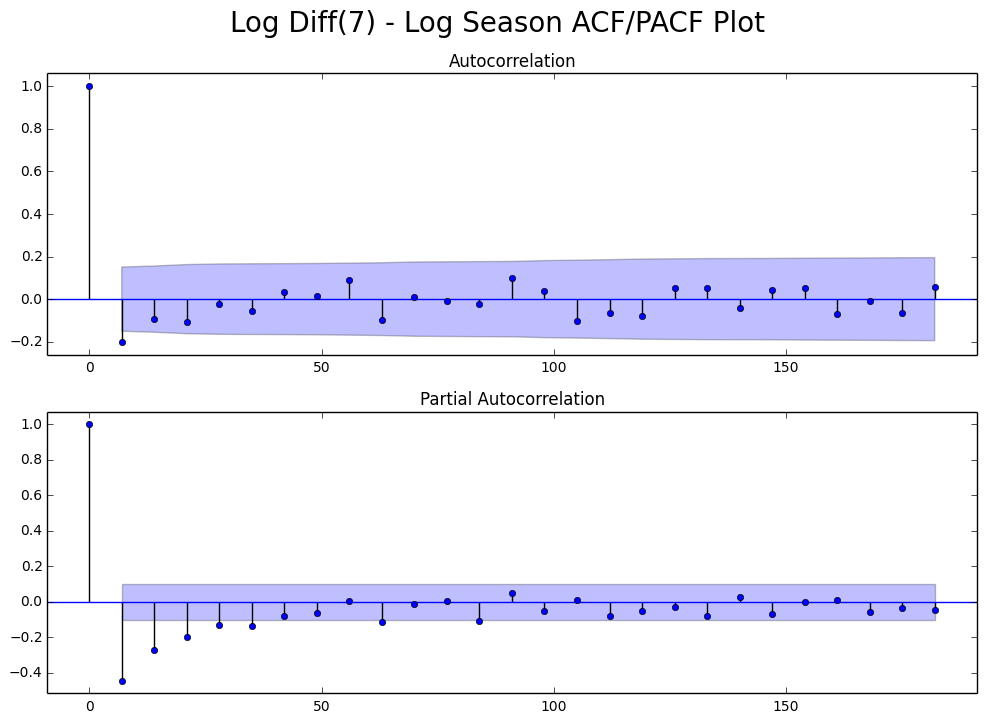

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_season, lags=range(0,183, 7), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_season, lags=range(0,183, 7), ax=ax2)
fig.suptitle('Log Diff(7) - Log Season ACF/PACF Plot', fontsize=20)

### - Unclear...both tails off...
### - Let's see detrended seasonal -> temp_A_diff - temp_A_diff.shift(7)

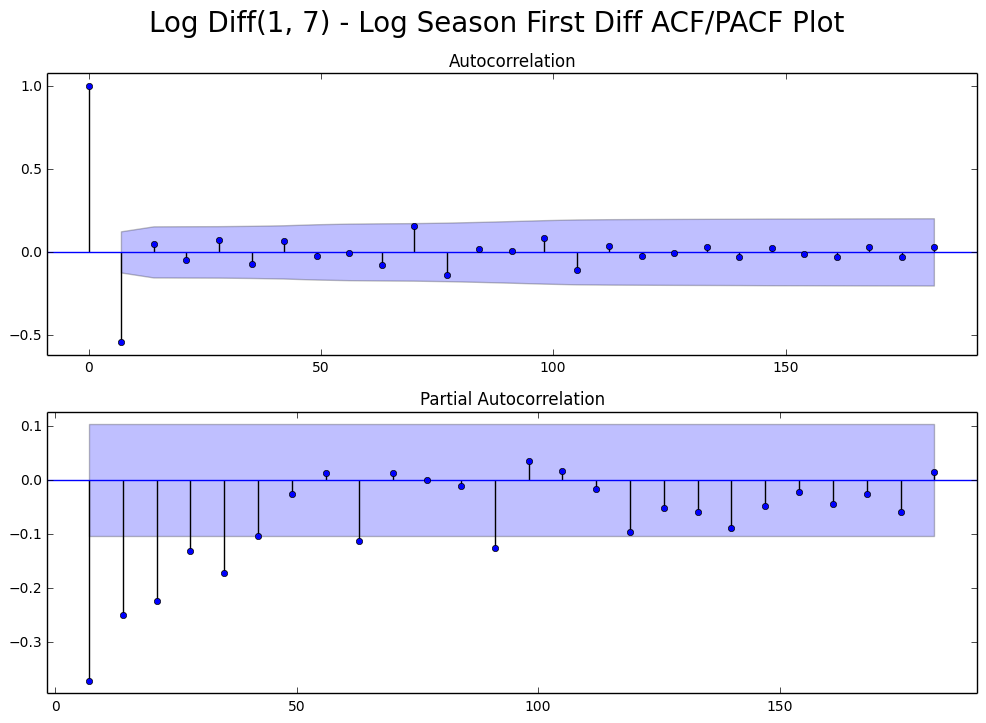

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_season_diff, lags=range(0, 183, 7), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_season_diff, lags=range(7, 183, 7), ax=ax2)
fig.suptitle('Log Diff(1, 7) - Log Season First Diff ACF/PACF Plot', fontsize=20)

### - ACF cuts of at 1...SMA(1)
### - PACF tails off
### - SARIMA(0, 1, 1)

In [31]:
mod = sm.tsa.statespace.SARIMAX(temp_A_log, trend='n', order=(0,1,1), seasonal_order=(1,1,1,7))
results_1 = mod.fit()
print results_1.summary()

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                  371
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -525.553
Date:                           Thu, 16 Feb 2017   AIC                           1059.105
Time:                                   14:23:26   BIC                           1074.770
Sample:                               09-26-2015   HQIC                          1065.327
                                    - 09-30-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5626      0.030    -18.836      0.000      -0.621      -0.504
ar.S.L7        0.0381      0.051      0.750

In [32]:
# This seems to generate better AIC/BIC...
mod = sm.tsa.statespace.SARIMAX(temp_A_log, trend='n', order=(1,1,1), seasonal_order=(1,1,1,7))
results_2 = mod.fit()
print results_2.summary()

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                  371
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -523.684
Date:                           Thu, 16 Feb 2017   AIC                           1057.368
Time:                                   14:23:39   BIC                           1076.949
Sample:                               09-26-2015   HQIC                          1065.145
                                    - 09-30-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1652      0.081      2.048      0.041       0.007       0.323
ma.L1         -0.6665      0.071     -9.370

In [33]:
# This seems to generate better AIC/BIC...
mod = sm.tsa.statespace.SARIMAX(temp_A_log, trend='n', order=(0,1,1), seasonal_order=(0,1,1,7))
results_3 = mod.fit()
print results_3.summary()

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                  371
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -525.723
Date:                           Thu, 16 Feb 2017   AIC                           1057.446
Time:                                   14:23:53   BIC                           1069.195
Sample:                               09-26-2015   HQIC                          1062.112
                                    - 09-30-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5571      0.030    -18.743      0.000      -0.615      -0.499
ma.S.L7       -0.8969      0.022    -40.113

In [34]:
residuals = pd.DataFrame(results_3.resid)
print residuals.head()
print residuals.describe()

                   0
2015-09-26  4.197503
2015-09-27  0.396811
2015-09-28  1.412017
2015-09-29  0.168417
2015-09-30 -0.078987
                0
count  371.000000
mean     0.022220
std      1.052319
min     -5.542617
25%     -0.262415
50%      0.069295
75%      0.526952
max      4.197503


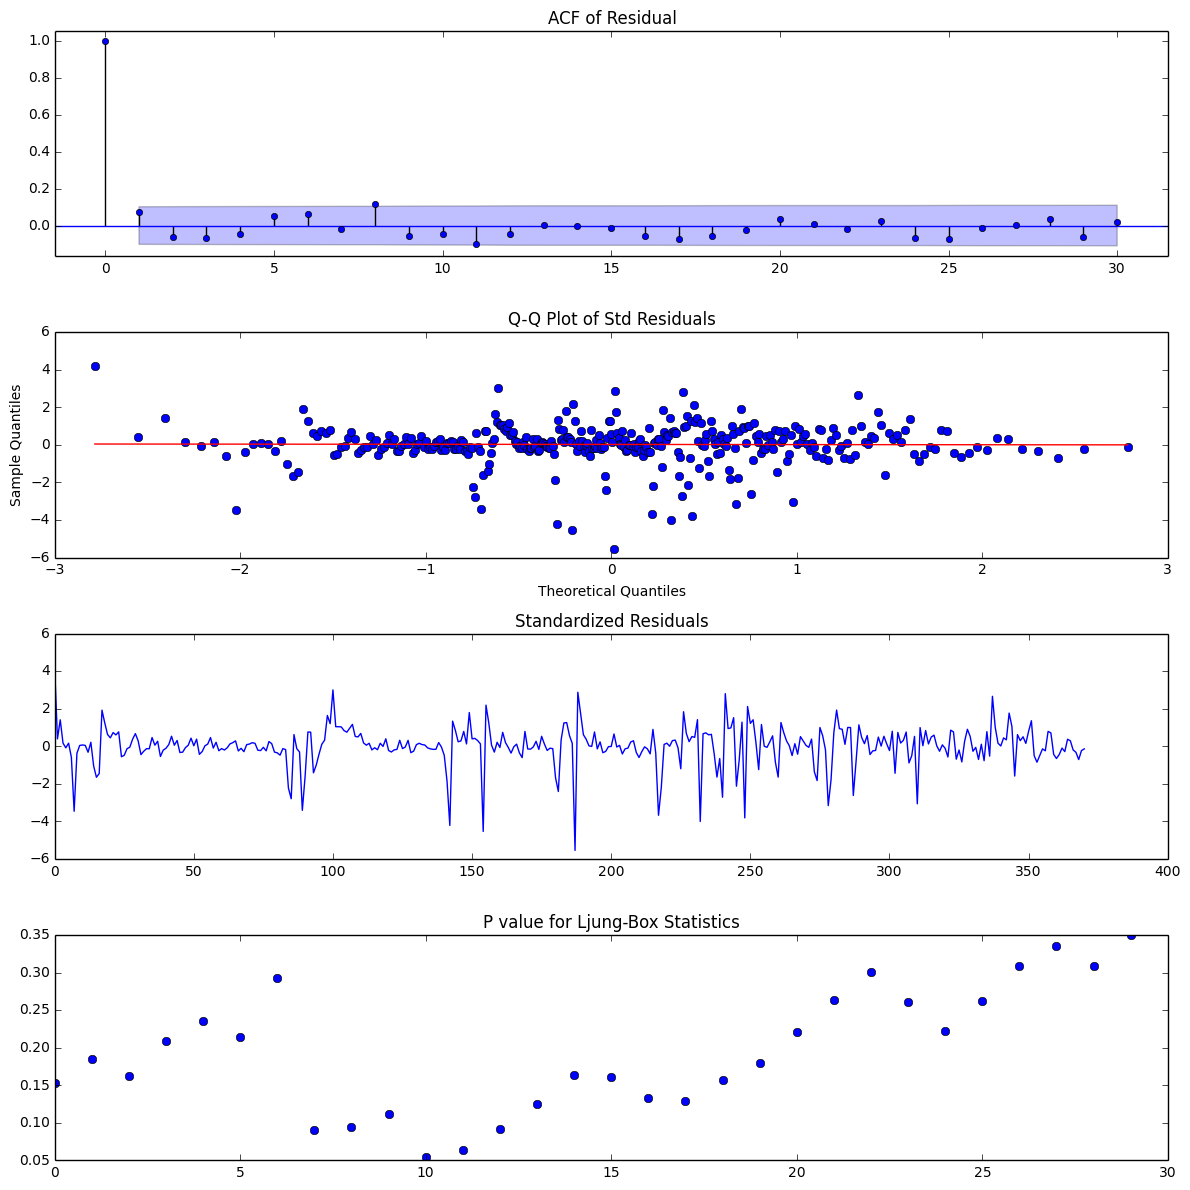

In [36]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(411)
ax1 = sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax1, title='ACF of Residual')

ax2 = fig.add_subplot(412)
ax2.title.set_text('Q-Q Plot of Std Residuals')
ax2 = qqplot(residuals, line='r', ax=plt.gca())

# Plot residual errors.
ax3 = fig.add_subplot(413)
ax3.title.set_text('Standardized Residuals')
ax3 = plt.plot(residuals)
# residuals.plot(kind='kde')

temp_q_stat = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=30)
ax4 = fig.add_subplot(414)
ax4.title.set_text('P value for Ljung-Box Statistics')
ax4 = plt.plot(temp_q_stat[1], 'o')
# print temp_q_stat[0]

plt.tight_layout()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


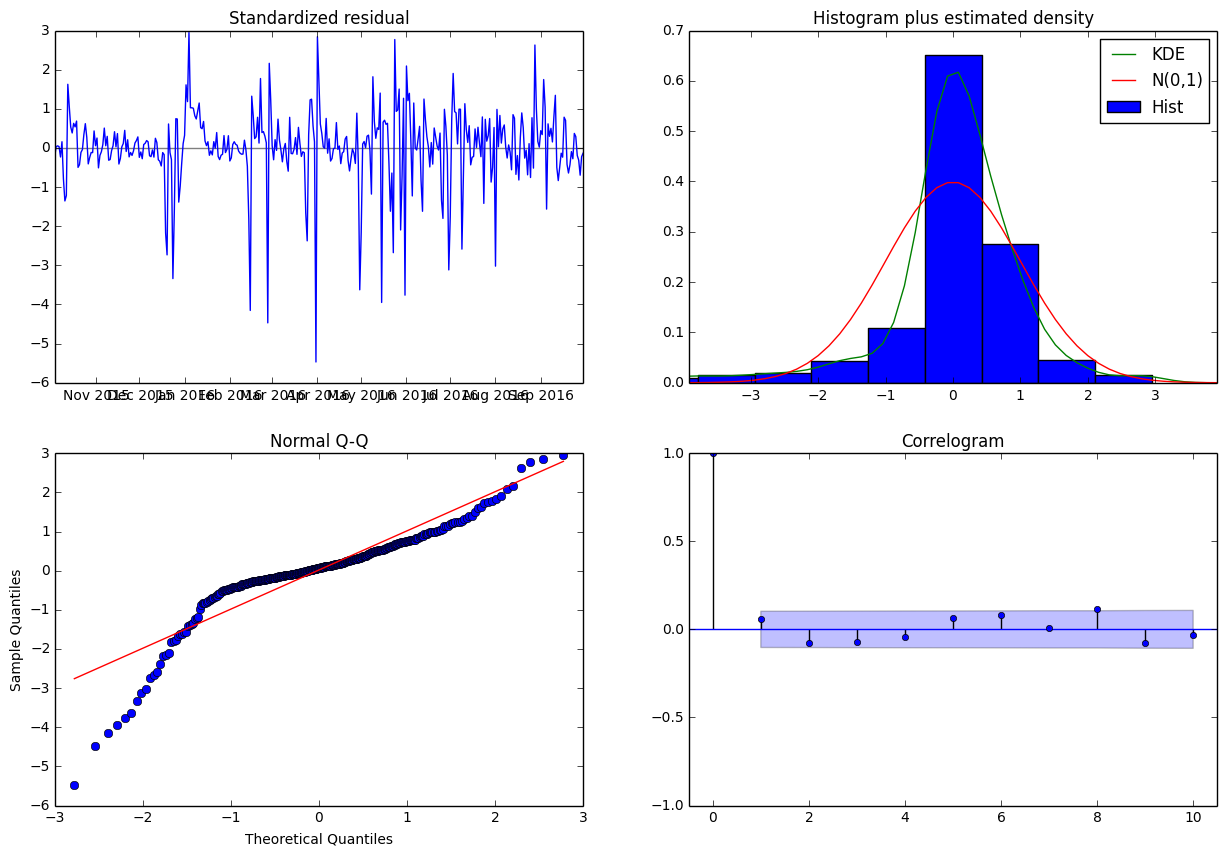

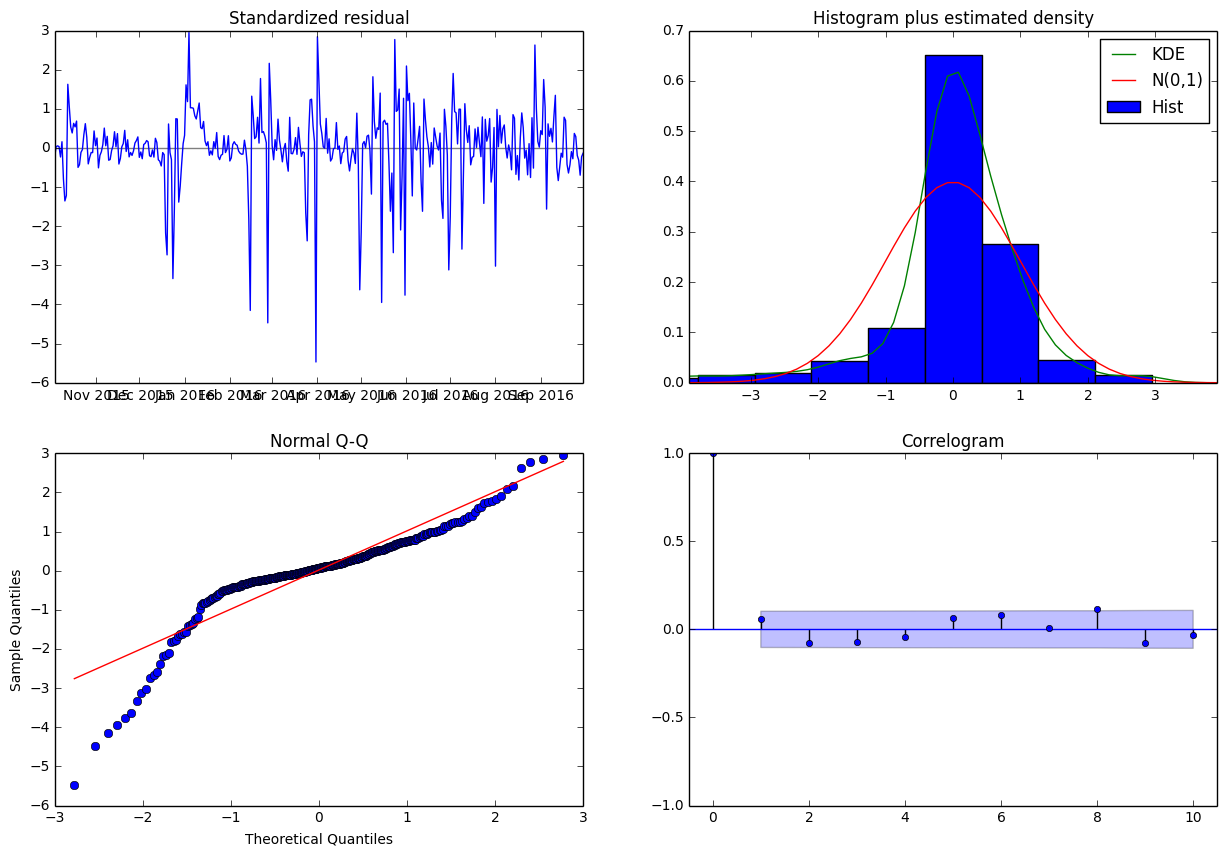

In [37]:
results_3.plot_diagnostics(figsize=(15,10))

# Prediction In Sample, and 90 Days Ahead

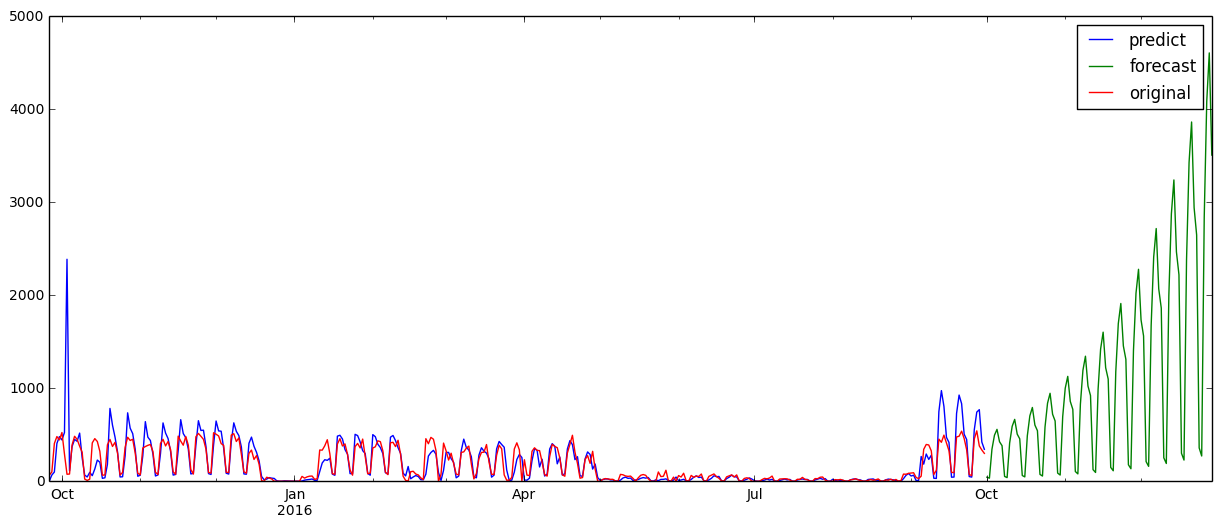

In [38]:
pred = np.exp(results_3.predict())
pred_90 = np.exp(results_3.predict(start=len(temp_A_log), end=len(temp_A_log)+90, dynamic=False))
forecast_90 = np.exp(results_3.forecast(steps=90))

pred.plot(label='predict')
# pred_90.plot(label='pred_90')
forecast_90.plot(label='forecast')

temp_A.plot(label='original')
plt.legend()

In [39]:
# report performance
mse = mean_squared_error(temp_A, pred)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 155.887


2016-10-01     43.432610
2016-10-02     32.886092
2016-10-03    343.703513
2016-10-04    494.933518
2016-10-05    557.941544
Freq: D, dtype: float64 

2016-10-01     43.432610
2016-10-02     32.886092
2016-10-03    343.703513
2016-10-04    494.933518
2016-10-05    557.941544
Freq: D, dtype: float64


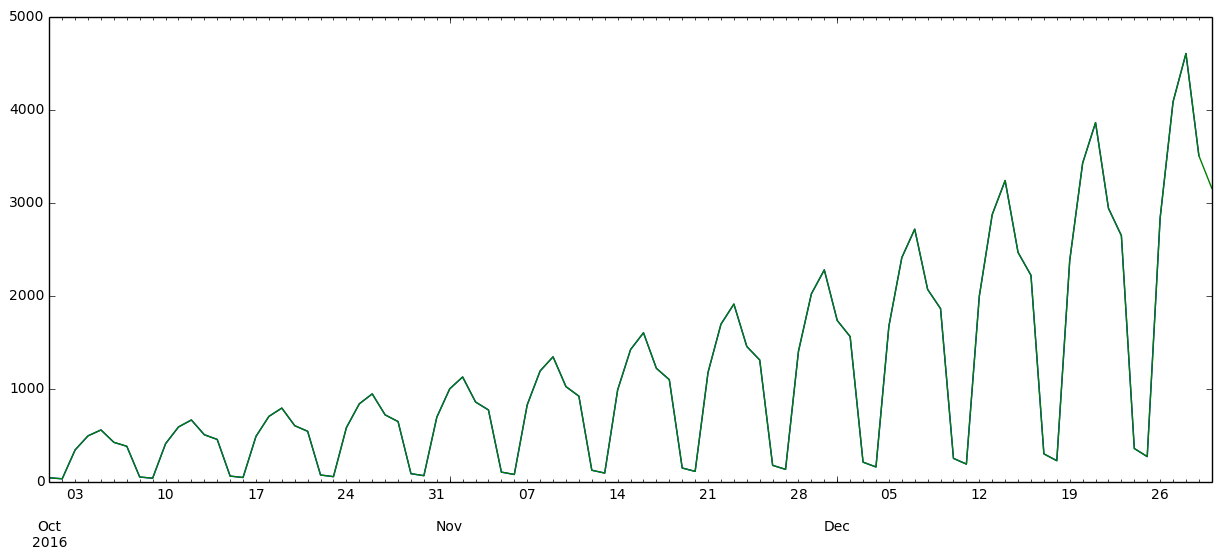

In [40]:
print pred_90.head(), '\n'
print forecast_90.head()
forecast_90.plot()
pred_90.plot()